In [1]:
%load_ext autoreload
%autoreload 1
print('autoreload')

import SimpleITK as sitk
import os, sys

print('simpleitk,os,sys')

sys.path.append('./workflow/libs/')
%aimport utils
%aimport config
%aimport segment 
%aimport match 
%aimport missingness 
%aimport register 
%aimport evaluate 
%aimport qc 

print('libs')

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sbn

print('other')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output

pd.set_option('display.max_columns', None)
# May be necessary to "Trust" the notebook in order to get the widgets to work. 

import time
import threading
#import multiprocessing
#from mantichora import mantichora

# the seaborn warnings are annoying
import warnings
warnings.filterwarnings('ignore')

autoreload
simpleitk,os,sys
libs
other


# Results Visualization 

Tool for interacting with results on exahead. 


## Overview

The file `aggregated_results.csv` is formed from three different sources: 
- each core-directory's parsed names: This contains the core name and the absolute path; This can be used to track and organize the data.
- the original core segmentation stats: this will include the original file name and segmentation statistics. 
- registration results: This contains registration success metrics 

Because of this, there is substantial missingness between row observations depending on which source it came from. 

## Data Dictionary 



In [2]:
data_dict = pd.read_csv('./workflow/libs/data_dict.csv', sep='\t')
#data_dict

In [3]:
w = widgets.Dropdown(
    options=data_dict.name.values,
    value=data_dict.name.values[0],
    description='feature name',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value': 
        print(data_dict[lambda x: x.name == change["new"]]['def'].item(), end='\r')

w.observe(on_change)
display(w)

Dropdown(description='feature name', options=('status', 'core', 'round', 'color_channel', 'path', 'center_x/y'…

# Read registration results into memory

In [14]:
res = pd.read_csv('/home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/aggregated_results.csv')

# select only registered results -- keep R0 unregistered as this is the aligned reference 
res = res[(res.status == 'registered') | (res['round'] == 'R0')]

res.head()

status  core round color_channel  \
2  unregistered     1    R0            c3   
3    registered     1    R2            c3   
4    registered     1    R1            c1   
7  unregistered     1    R0            c5   
8    registered     1    R2            c4   

                                        path  \
2  unregistered_core=1_round=R0_color=c3.tif   
3    registered_core=1_round=R2_color=c3.tif   
4    registered_core=1_round=R1_color=c1.tif   
7  unregistered_core=1_round=R0_color=c5.tif   
8    registered_core=1_round=R2_color=c4.tif   

                                            img_name  \
2                                                NaN   
3                                                NaN   
4  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...   
7                                                NaN   
8                                                NaN   

                     protein  center_x  center_y  width  height  \
2                        NaN       296      1065    143     231   
3                        NaN       271      1075    141     353   
4  H3K27me3.CCNB1.CCND1.Ki67       287      1088    139     227   
7                        NaN       296      1065    143     231   
8                        NaN       271      1075    141     353   

   Volume (nm^3)  Elongation  Flatness  \
2       0.945760    1.897392  1.897392   
3       1.415155    3.094666  3.094666   
4       0.895441    1.905274  1.905274   
7       0.945760    1.897392  1.897392   
8       1.415155    3.094666  3.094666   

   Oriented Bounding Box Minimum Size(nm)  \
2                                0.936080   
3                                0.936058   
4                                0.906336   
7                                0.936080   
8                                0.936058   

   Oriented Bounding Box Maximum Size(nm)  Intensity Mean  \
2                                1.523790       16.939468   
3                                2.318472       13.913689   
4                                1.500952       17.966500   
7                                1.523790       16.939468   
8                                2.318472       13.913689   

   Intensity Standard Deviation  Intensity Skewness  component slide_name  \
2                     23.038116            2.398662          1         S3   
3                     41.654889            4.833200          1         S3   
4                     24.980206            2.363784          1         S3   
7                     23.038116            2.398662          1         S3   
8                     41.654889            4.833200          1         S3   

         date  scan_id    scene note  jacaard_coef  dice_coef  \
2  2020-01-21    13471  Scene-1  ORG           NaN        NaN   
3  2020-01-23    13492  Scene-1  ORG      0.323354   0.488689   
4  2020-01-22    13485  Scene-1  ORG      0.570099   0.726195   
7  2020-01-21    13471  Scene-1  ORG           NaN        NaN   
8  2020-01-23    13492  Scene-1  ORG      0.323354   0.488689   

   volume_similarity  false_pos_err  false_neg_err  hausdorff_dist  \
2                NaN            NaN            NaN             NaN   
3           0.130959       0.541344       0.477070        0.091557   
4          -0.013710       0.268793       0.278749        0.054266   
7                NaN            NaN            NaN             NaN   
8           0.130959       0.541344       0.477070        0.091557   

                                     registered_path  
2  /home/exacloud/lustre1/NGSdev/evansna/cyclicIF...  
3  /home/exacloud/lustre1/NGSdev/evansna/cyclicIF...  
4  /home/exacloud/lustre1/NGSdev/evansna/cyclicIF...  
7  /home/exacloud/lustre1/NGSdev/evansna/cyclicIF...  
8  /home/exacloud/lustre1/NGSdev/evansna/cyclicIF...

## Available experiments 

### Choose experiment from drop down menu

In [15]:
options = res[['slide_name', 'scene']].drop_duplicates().dropna()

opt = [f'{x.slide_name} - {x.scene}' for i,x in options.iterrows()]
_exp = widgets.Dropdown(
    options=opt,
    value=opt[0],
    description='Experiment',
    disabled=False,
)
_exp

Dropdown(description='Experiment', options=('S3 - Scene-1',), value='S3 - Scene-1')

### filter the aggregated results 

In [16]:
SLIDE, SCENE = _exp.value.split(' - ')
res = res[(res.slide_name == SLIDE) & (res.scene == SCENE)]

## Registration results 

# Registration Results 

Why is there such clear separation between rounds? 
- something to do with lost material? I guess we would expect later rounds to register more poorly... 

Note: R1 has better metrics than R2. 

In [17]:
# select only the DAPI results
regRes = res[res.color_channel == 'c1']
vizRes = regRes[['round',*'jacaard_coef,dice_coef,volume_similarity,false_neg_err,false_pos_err,hausdorff_dist'.split(',')]]

# basic stats
vizRes.describe()

jacaard_coef   dice_coef  volume_similarity  false_neg_err  \
count    159.000000  159.000000         159.000000     159.000000   
mean       0.590351    0.725713           0.029829       0.262611   
std        0.170474    0.160126           0.159978       0.151202   
min        0.008541    0.016937          -0.296685       0.018245   
25%        0.503396    0.669666          -0.040598       0.174393   
50%        0.612614    0.759777           0.016723       0.230670   
75%        0.718445    0.836157           0.065646       0.305440   
max        0.969828    0.984683           1.070265       0.982713   

       false_pos_err  hausdorff_dist  
count     159.000000      159.000000  
mean        0.277640        0.057929  
std         0.177268        0.068576  
min         0.010536        0.005993  
25%         0.147187        0.014570  
50%         0.242996        0.025425  
75%         0.356023        0.073779  
max         0.983399        0.311283

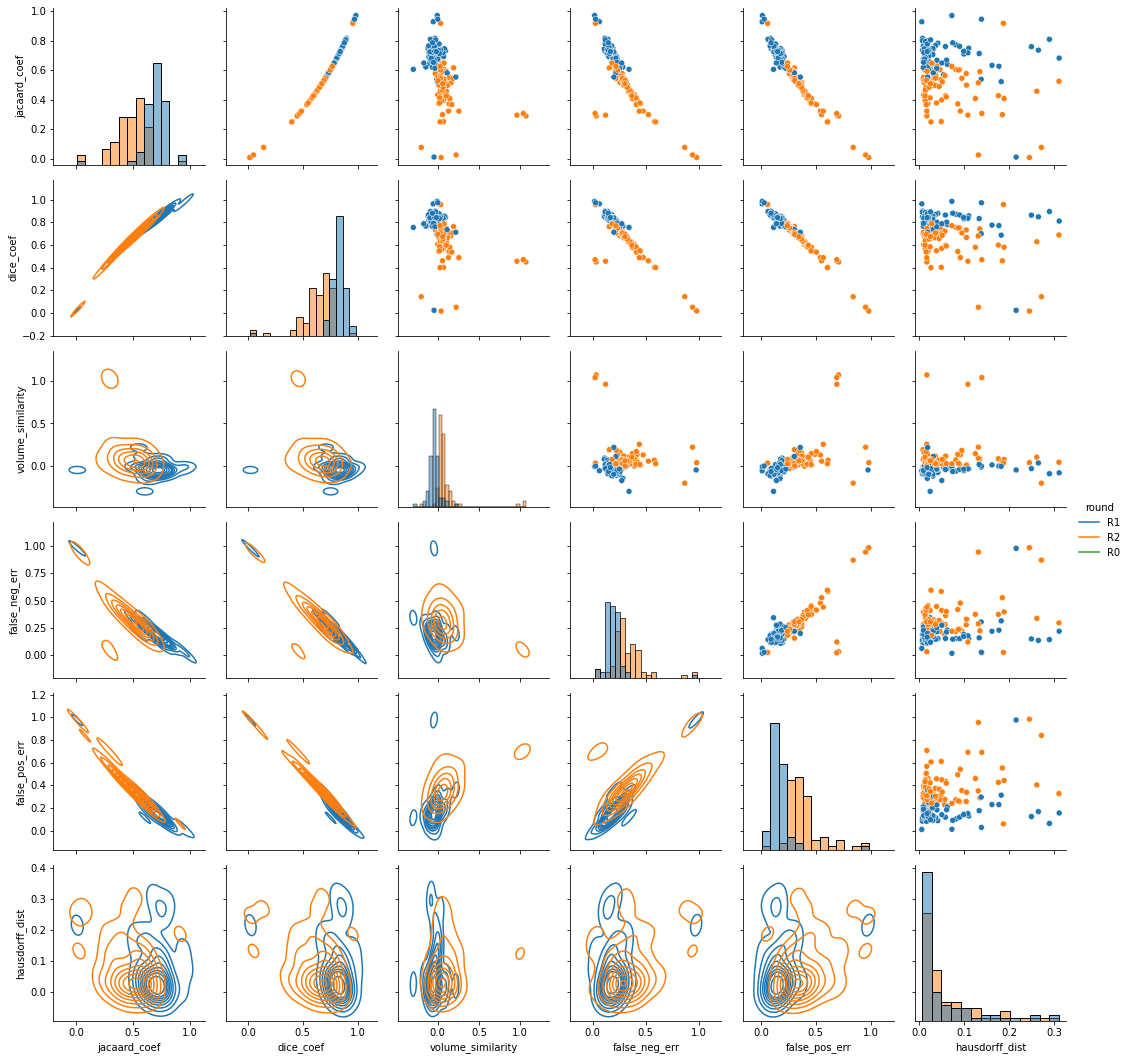

In [20]:
g = sbn.PairGrid(vizRes, hue='round')
g.map_upper(sbn.scatterplot)
g.map_diag(sbn.histplot)
g.map_lower(sbn.kdeplot)
g.add_legend()

## Manual thresholding 

We'll just use rational thresholds for now. Need further verification and tuning. 

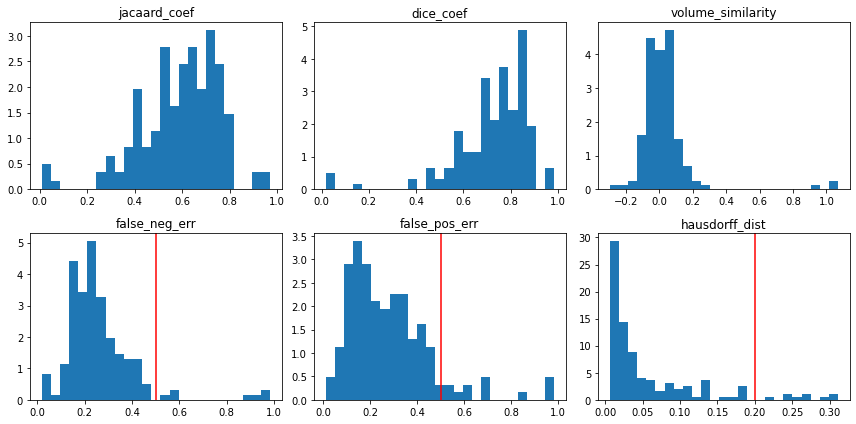

In [21]:
# for the top row, higher is better 
# for the bottom row, lower is better 

f, axes = plt.subplots(2,3, figsize=(12,6))

for name,ax in zip(vizRes.columns.values[1:], axes.flat): 
    ax.hist(vizRes[name], bins=25, density=True)
    ax.set_title(name)

# add thresholds for viz     
axes.flat[3].axvline(config.FNR_threshold, c='r')  
axes.flat[4].axvline(config.FPR_threshold, c='r')
axes.flat[5].axvline(config.hausdorff_distance_threshold, c='r')

plt.tight_layout()
plt.show()

In [22]:
outRes = regRes[lambda x: (x.false_pos_err > config.FPR_threshold) | (x.false_neg_err > config.FNR_threshold) | (x.hausdorff_dist > config.hausdorff_distance_threshold)]

print(f'number of outliers: {outRes.shape[0]}/{regRes.shape[0]} [{100*outRes.shape[0]/regRes.shape[0]:.1f}%]')

number of outliers: 19/239 [7.9%]


## inspect possible outliers

##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.3233540233855156
dice: 0.4886886164569692
volume similarity: 0.13095872323765806
FPR: 0.5413438926545857
FNR: 0.4770702792572854
hausdorff dist: 0.09155727273817067
review the segmentations to make sure the look appropriate for comparison...


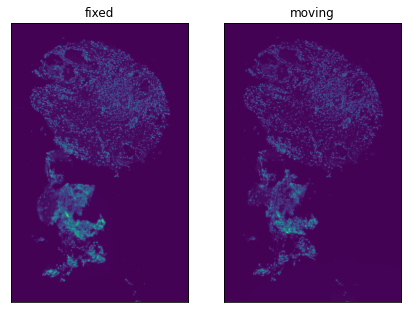

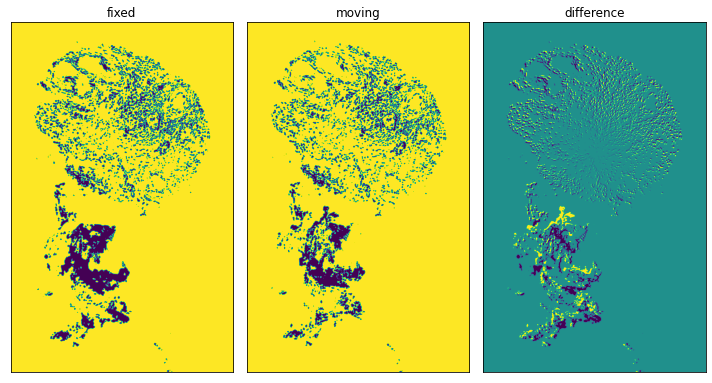

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.3233540233855156, 'dice_coef': 0.48868861645696915, 'volume_similarity': 0.13095872323765803, 'false_neg_err': 0.47707027925728535, 'false_pos_err': 0.5413438926545857, 'hausdorff_dist': 0.09155727273817069}
##################################################
R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.011837729648061185
dice: 0.02339847448103877
volume similarity: -0.045242181907745364
FPR: 0.976059976059976
FNR: 0.9771191160753264
hausdorff dist: 0.21561474961006705
review the segmentations to make sure the look appropriate for comparison...


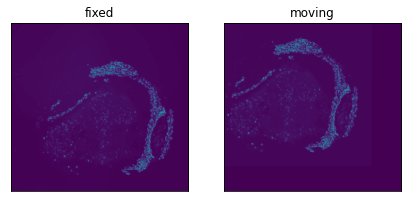

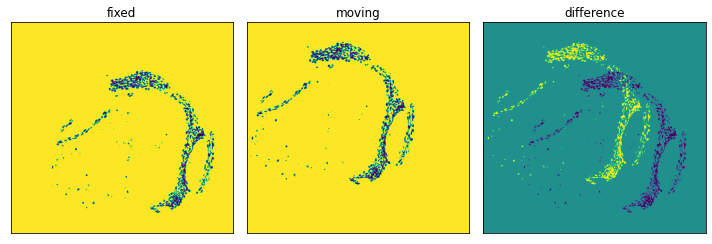

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.011837729648061183, 'dice_coef': 0.02339847448103877, 'volume_similarity': -0.04524218190774536, 'false_neg_err': 0.9771191160753263, 'false_pos_err': 0.9760599760599761, 'hausdorff_dist': 0.21561474961006702}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.008540844522595964
dice: 0.016937032484071315
volume similarity: 0.04054282064261094
FPR: 0.9833994833994834
FNR: 0.9827125260378226
hausdorff dist: 0.2450625019010176
review the segmentations to make sure the look appropriate for comparison...


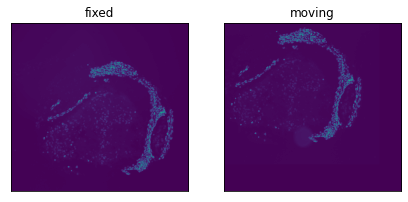

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.008540844522595964, 'dice_coef': 0.016937032484071315, 'volume_similarity': 0.04054282064261094, 'false_neg_err': 0.9827125260378226, 'false_pos_err': 0.9833994833994834, 'hausdorff_dist': 0.24506250190101758}
##################################################
R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.8088857478225974
dice: 0.8943469744247522
volume similarity: -0.08926387777307485
FPR: 0.06387180938160296
FNR: 0.14386403370164305
hausdorff dist: 0.2895601608052865
review the segmentations to make sure the look appropriate for comparison...


for comparison:
{'name': 'for disp', 'jacaard_coef': 0.8088857478225974, 'dice_coef': 0.894346974424752, 'volume_similarity': -0.08926387777307485, 'false_neg_err': 0.14386403370164305, 'false_pos_err': 0.06387180938160296, 'hausdorff_dist': 0.28956016080528646}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.4574545534098464
dice: 0.6277445184682983
volume similarity: 0.10437780351795377
FPR: 0.4033918078599021
FNR: 0.3376902637737775
hausdorff dist: 0.2615959653579342
review the segmentations to make sure the look appropriate for comparison...


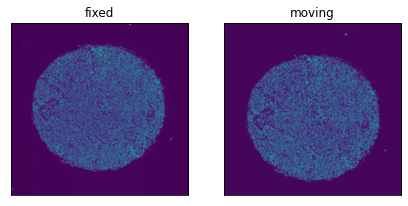

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.45745455340984637, 'dice_coef': 0.6277445184682983, 'volume_similarity': 0.10437780351795377, 'false_neg_err': 0.3376902637737775, 'false_pos_err': 0.4033918078599021, 'hausdorff_dist': 0.2615959653579342}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.25189030805384305
dice: 0.40241594081102094
volume similarity: 0.06955647536541497
FPR: 0.6111090027248783
FNR: 0.5830844718576322
hausdorff dist: 0.04914679088866152
review the segmentations to make sure the look appropriate for comparison...


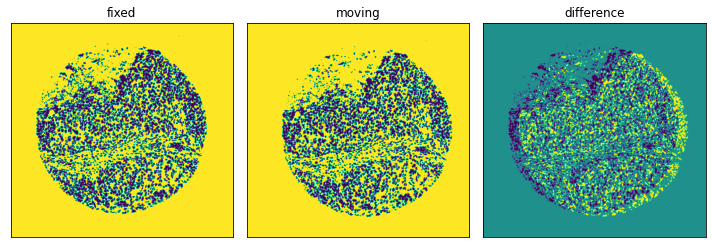

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.25189030805384305, 'dice_coef': 0.40241594081102094, 'volume_similarity': 0.06955647536541497, 'false_neg_err': 0.5830844718576322, 'false_pos_err': 0.6111090027248783, 'hausdorff_dist': 0.049146790888661515}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.2988873911554749
dice: 0.4602206368168501
volume similarity: 0.05809346476329037
FPR: 0.5527699351887482
FNR: 0.5260115474499382
hausdorff dist: 0.18504821470463584
review the segmentations to make sure the look appropriate for comparison...


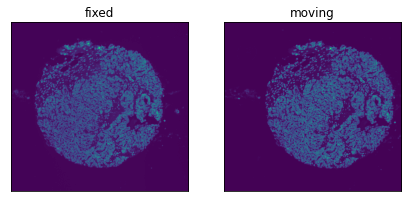

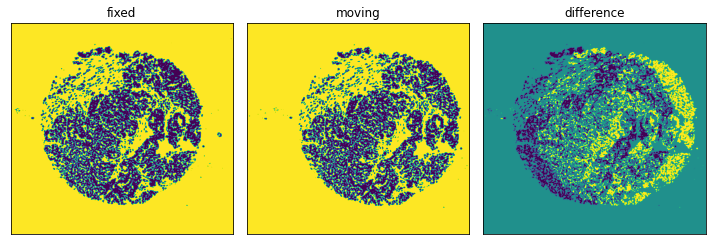

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.29888739115547486, 'dice_coef': 0.4602206368168501, 'volume_similarity': 0.05809346476329037, 'false_neg_err': 0.5260115474499382, 'false_pos_err': 0.5527699351887482, 'hausdorff_dist': 0.18504821470463584}
##################################################
R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.7586662295696155
dice: 0.8627745467714789
volume similarity: -0.02912592403229586
FPR: 0.12447521910007912
FNR: 0.14960965551416705
hausdorff dist: 0.24958260412985345
review the segmentations to make sure the look appropriate for comparison...


for comparison:
{'name': 'for disp', 'jacaard_coef': 0.7586662295696155, 'dice_coef': 0.862774546771479, 'volume_similarity': -0.02912592403229586, 'false_neg_err': 0.14960965551416705, 'false_pos_err': 0.12447521910007912, 'hausdorff_dist': 0.24958260412985345}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.07735049299628452
dice: 0.14359392509518493
volume similarity: -0.19986944791617933
FPR: 0.8404627654044742
FNR: 0.8694523211536903
hausdorff dist: 0.27181983305186985
review the segmentations to make sure the look appropriate for comparison...


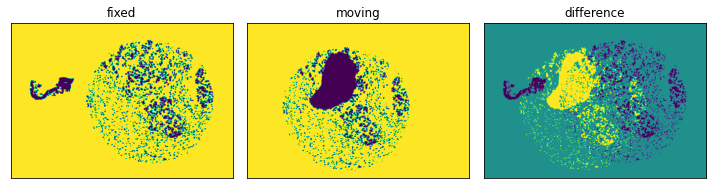

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.07735049299628452, 'dice_coef': 0.14359392509518493, 'volume_similarity': -0.19986944791617933, 'false_neg_err': 0.8694523211536903, 'false_pos_err': 0.8404627654044742, 'hausdorff_dist': 0.27181983305186985}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.29562093037440096
dice: 0.4563386148585514
volume similarity: 0.9607772929128084
FPR: 0.6917440457606279
FNR: 0.1217693536785579
hausdorff dist: 0.10846376614739577
review the segmentations to make sure the look appropriate for comparison...


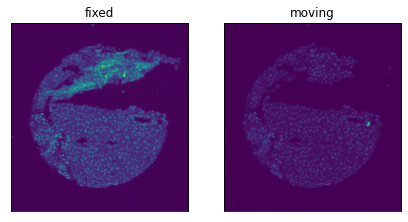

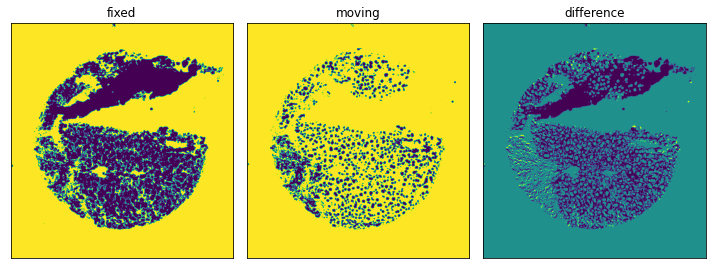

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.29562093037440096, 'dice_coef': 0.45633861485855143, 'volume_similarity': 0.9607772929128084, 'false_neg_err': 0.1217693536785579, 'false_pos_err': 0.6917440457606279, 'hausdorff_dist': 0.10846376614739575}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.2899696778897137
dice: 0.4495759595901211
volume similarity: 1.0702645074484038
FPR: 0.7071418710020206
FNR: 0.03289491862617778
hausdorff dist: 0.017160402028433268
review the segmentations to make sure the look appropriate for comparison...


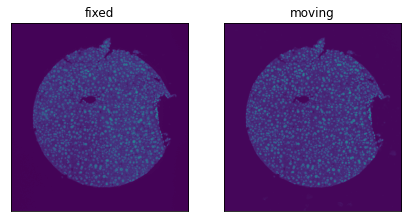

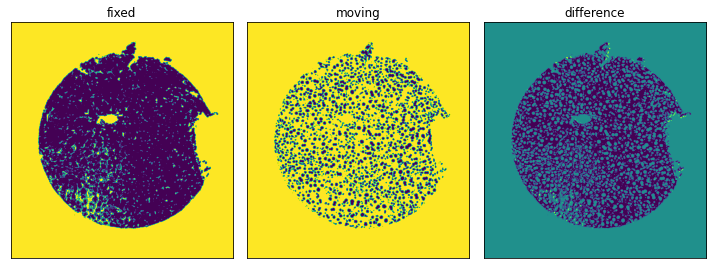

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.2899696778897137, 'dice_coef': 0.44957595959012103, 'volume_similarity': 1.0702645074484038, 'false_neg_err': 0.03289491862617778, 'false_pos_err': 0.7071418710020206, 'hausdorff_dist': 0.01716040202843327}
##################################################
R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.7356008202323991
dice: 0.8476612959123876
volume similarity: 0.03703867069105665
FPR: 0.1677513950927381
FNR: 0.13634437596302004
hausdorff dist: 0.2650687313206587
review the segmentations to make sure the look appropriate for comparison...


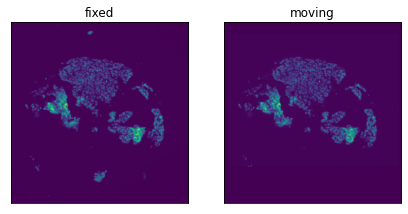

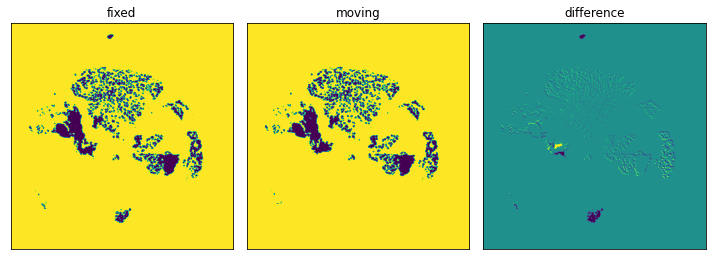

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.7356008202323991, 'dice_coef': 0.8476612959123876, 'volume_similarity': 0.03703867069105665, 'false_neg_err': 0.13634437596302004, 'false_pos_err': 0.1677513950927381, 'hausdorff_dist': 0.2650687313206587}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.5242124699365507
dice: 0.6878469770797406
volume similarity: 0.04528496969556679
FPR: 0.3273827488380516
FNR: 0.2962176415325223
hausdorff dist: 0.3107500325345943
review the segmentations to make sure the look appropriate for comparison...


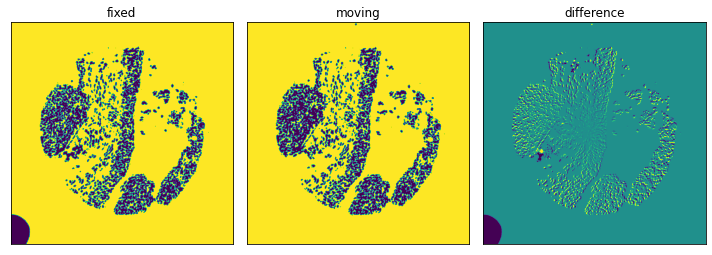

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.5242124699365507, 'dice_coef': 0.6878469770797406, 'volume_similarity': 0.04528496969556679, 'false_neg_err': 0.2962176415325223, 'false_pos_err': 0.3273827488380516, 'hausdorff_dist': 0.31075003253459427}
##################################################
R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.6817097433678739
dice: 0.8107341306147738
volume similarity: -0.07904572622241869
FPR: 0.155904810768395
FNR: 0.2200901400202868
hausdorff dist: 0.3112832178681603
review the segmentations to make sure the look appropriate for comparison...


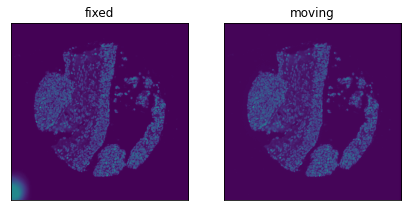

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.6817097433678739, 'dice_coef': 0.8107341306147738, 'volume_similarity': -0.07904572622241869, 'false_neg_err': 0.22009014002028673, 'false_pos_err': 0.155904810768395, 'hausdorff_dist': 0.3112832178681603}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.36675691012697137
dice: 0.5366819913760666
volume similarity: 0.17063624214482498
FPR: 0.5055072047946952
FNR: 0.4132583100855832
hausdorff dist: 0.015734751088550342
review the segmentations to make sure the look appropriate for comparison...


for comparison:
{'name': 'for disp', 'jacaard_coef': 0.36675691012697137, 'dice_coef': 0.5366819913760666, 'volume_similarity': 0.17063624214482498, 'false_neg_err': 0.4132583100855832, 'false_pos_err': 0.5055072047946952, 'hausdorff_dist': 0.015734751088550335}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.2497803608839629
dice: 0.3997188125236576
volume similarity: 0.028010598604877517
FPR: 0.60580204778157
FNR: 0.5946034879894703
hausdorff dist: 0.02632285510070737
review the segmentations to make sure the look appropriate for comparison...


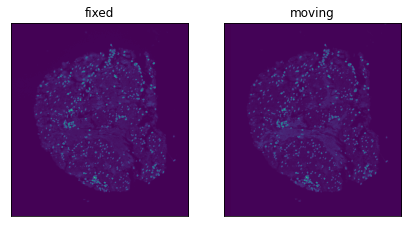

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.24978036088396297, 'dice_coef': 0.3997188125236576, 'volume_similarity': 0.02801059860487752, 'false_neg_err': 0.5946034879894703, 'false_pos_err': 0.60580204778157, 'hausdorff_dist': 0.02632285510070737}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.3069242069321476
dice: 0.4696893749525329
volume similarity: 1.0388361476080774
FPR: 0.6908754851279272
FNR: 0.022665336854526045
hausdorff dist: 0.13939206509401006
review the segmentations to make sure the look appropriate for comparison...


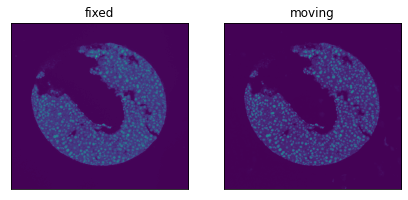

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.30692420693214756, 'dice_coef': 0.4696893749525329, 'volume_similarity': 1.0388361476080774, 'false_neg_err': 0.022665336854526045, 'false_pos_err': 0.6908754851279272, 'hausdorff_dist': 0.13939206509401006}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.3225422074193178
dice: 0.4877609283240884
volume similarity: 0.2562009487315871
FPR: 0.5676263423270852
FNR: 0.4405766788675581
hausdorff dist: 0.017160402028433188
review the segmentations to make sure the look appropriate for comparison...


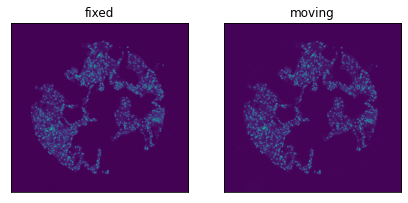

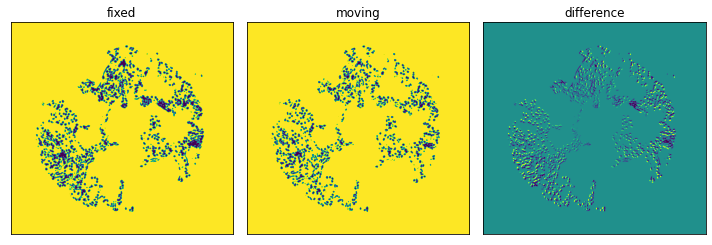

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.3225422074193178, 'dice_coef': 0.4877609283240884, 'volume_similarity': 0.2562009487315871, 'false_neg_err': 0.4405766788675581, 'false_pos_err': 0.5676263423270852, 'hausdorff_dist': 0.017160402028433188}
##################################################
R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
##################################################
jacaard: 0.02603541153087096
dice: 0.05074953795605448
volume similarity: 0.22260250530494904
FPR: 0.9543332306744688
FNR: 0.942894554417315
hausdorff dist: 0.13175704770598715
review the segmentations to make sure the look appropriate for comparison...


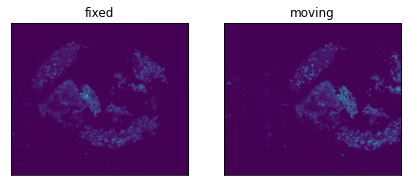

for comparison:
{'name': 'for disp', 'jacaard_coef': 0.02603541153087096, 'dice_coef': 0.05074953795605448, 'volume_similarity': 0.22260250530494902, 'false_neg_err': 0.942894554417315, 'false_pos_err': 0.9543332306744687, 'hausdorff_dist': 0.13175704770598717}


In [27]:
# for each core 
for i, row in outRes.iterrows(): 
    #print(row) # uncomment this to see all information
    print('#'*50)
    print(row['img_name'])
    print('#'*50)
    print('jacaard:', row.jacaard_coef)
    print('dice:', row.dice_coef)
    print('volume similarity:', row.volume_similarity)
    print('FPR:', row.false_pos_err)
    print('FNR:', row.false_neg_err)
    print('hausdorff dist:', row.hausdorff_dist)
    img = sitk.ReadImage(row.registered_path)
    #utils.myshow(img)
    
    R0_dapi_path = f'{"/".join(row.registered_path.split("/")[:-1])}/unregistered_core={int(row.core)}_round=R0_color=c1.tif'
    
    R0_img = sitk.ReadImage(R0_dapi_path)
    #utils.myshow(img)
    
    f, axes = plt.subplots(1,2, figsize=(7,14))
    utils.myshow(R0_img, title='fixed', ax=axes[0])
    utils.myshow(img, title='moving', ax=axes[1])
    
    _res = evaluate.eval_registration(R0_img, img, name='for disp', plot=True)
    print('for comparison:')
    print(_res)


# Registration Visualization

Build in some interactive widgets to visualize mapping. eg scroll select for which core(1) and round(R0 + 2) to include. 

Just a convenient way to pan through and visualize images. 

In [62]:
qc.choose_and_plot_core(output_dir='/home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output')

Dropdown(description='slide name:', index=1, options=('S3', 'None'), value='None')

Dropdown(description='scene:', index=1, options=('Scene-1', 'None'), value='None')

Dropdown(description='core:', index=80, options=('core-001', 'core-002', 'core-003', 'core-004', 'core-005', '…

##################################################


Dropdown(description='Red - Round:', options=('R0', 'R1', 'R2'), value='R0')

Dropdown(description='Red - color:', options=('c1', 'c2', 'c3', 'c4', 'c5'), value='c1')

Dropdown(description='Green - Round:', index=2, options=('R0', 'R1', 'R2'), value='R2')

Dropdown(description='Green - color:', options=('c1', 'c2', 'c3', 'c4', 'c5'), value='c1')

Dropdown(description='Blue - Round:', index=1, options=('R0', 'R1', 'R2'), value='R1')

Dropdown(description='Blue - color:', options=('c1', 'c2', 'c3', 'c4', 'c5'), value='c1')

Button(description='Generate Image', style=ButtonStyle(), tooltip='Click me')

plotting core image, this may take a moment...
Red channel --> /home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/S3/Scene-1/core-071/unregistered_core=71_round=R0_color=c1.tif
Blue channel --> /home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/S3/Scene-1/core-071/registered_core=71_round=R2_color=c1.tif
Green channel --> /home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/S3/Scene-1/core-071/registered_core=71_round=R1_color=c1.tif


# Recombine images


In [3]:
res = pd.read_csv('/home/exacloud/lustre1/NGSdev/evansna/cyclicIF/output/aggregated_results.csv')

# drop unnecessary columns 
res = res.drop(['Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)

# select only registered results -- keep R0 unregistered as this is the aligned reference 
res = res[(res.status == 'registered') | (res['round'] == 'R0')]

res.head()

status  core round color_channel  \
0  unregistered    56    R0            c1   
2    registered    56    R1            c1   
3    registered    56    R2            c3   
5  unregistered    56    R0            c4   
6    registered    56    R1            c4   

                                         path  center_x  center_y  width  \
0  unregistered_core=56_round=R0_color=c1.tif    1087.0    1094.0  126.0   
2    registered_core=56_round=R1_color=c1.tif    1079.0    1124.0  122.0   
3    registered_core=56_round=R2_color=c3.tif       NaN       NaN    NaN   
5  unregistered_core=56_round=R0_color=c4.tif       NaN       NaN    NaN   
6    registered_core=56_round=R1_color=c4.tif       NaN       NaN    NaN   

   height  Volume (nm^3)  Elongation  Flatness  \
0   120.0       0.497533    1.046273  1.046273   
2   117.0       0.470113    1.039698  1.039698   
3     NaN            NaN         NaN       NaN   
5     NaN            NaN         NaN       NaN   
6     NaN            NaN         NaN       NaN   

   Oriented Bounding Box Minimum Size(nm)  \
0                                0.793941   
2                                0.771342   
3                                     NaN   
5                                     NaN   
6                                     NaN   

   Oriented Bounding Box Maximum Size(nm)  Intensity Mean  \
0                                0.827308       14.144786   
2                                0.799247       14.819089   
3                                     NaN             NaN   
5                                     NaN             NaN   
6                                     NaN             NaN   

   Intensity Standard Deviation  Intensity Skewness  component  \
0                     14.124861            1.566738       56.0   
2                     14.666503            1.530970       55.0   
3                           NaN                 NaN        NaN   
5                           NaN                 NaN        NaN   
6                           NaN                 NaN        NaN   

                                            img_name  \
0  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__1347...   
2  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...   
3                                                NaN   
5                                                NaN   
6                                                NaN   

                     protein slide_name        date  scan_id    scene note  \
0    AF488.AF555.AF647.AF750         S3  2020-01-21  13471.0  Scene-1  ORG   
2  H3K27me3.CCNB1.CCND1.Ki67         S3  2020-01-22  13485.0  Scene-1  ORG   
3                        NaN        NaN         NaN      NaN      NaN  NaN   
5                        NaN        NaN         NaN      NaN      NaN  NaN   
6                        NaN        NaN         NaN      NaN      NaN  NaN   

  file_type                                           original  cluster  \
0       tif  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__1347...     56.0   
2       tif  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...     56.0   
3       NaN                                                NaN      NaN   
5       NaN                                                NaN      NaN   
6       NaN                                                NaN      NaN   

                                       name  jacaard_coef  dice_coef  \
0                                       NaN           NaN        NaN   
2  registered_core=56_round=R1_color=c1.tif      0.760846   0.864182   
3                                       NaN           NaN        NaN   
5                                       NaN           NaN        NaN   
6                                       NaN           NaN        NaN   

   volume_similarity  false_neg_err  false_pos_err  hausdorff_dist  \
0                NaN            NaN            NaN             NaN   
2            -0.0374       0.151681       0.119349         0.09009   
3                NaN            NaN          

# Restiching images 

### Quality Control 

This can be done using the `auto` flag, which will remove and cores that fall outside of the hardcoded thresholds (see `config.py` for details) **OR** by passing a list of `core` id's, which will be excluded from the restitched image. 

In [68]:
## NOTE QC methods need to be further tested. ##

## change/uncomment these values to modify QC method used ###################
#qc_method = None
#qc_method = 'auto'
qc_method = {'R0':[0,1,2,3,4,5], 'R1':[6,7,8,9,10], 'R2':[11,12,13,14,15]}
# the dictionary here will remove cores as specified within each round. eg. 
# in this example it'll remove cores 0-5 in R0, 6-10 in R1, 11-15 in R2 
#############################################################################

### MULTI THREADED restitching ### 
threads = []
print('assigning threads...', end='\n')
for _round in np.sort(res['round'].unique()): 
    _temp = res[lambda x: (x['round'] == _round)]
    for _channel in np.sort(_temp['color_channel'].unique()): 
        print(f'\t\t\t\t {(_round, _channel)}')
        
        # parse the dictionary for manual qc. 
        if type(qc_method) == type({}): 
            if _round in qc_method.keys(): 
                _qc_method = qc_method[_round]
            else: 
                _qc_method=None
        else: 
            _qc_method = qc_method

        # see qc.py for details                                dat, _round, _channel, qc=[None, 'auto', []], output_dir='../output/S3/Scene-1', save=True, verbose=True
        t = threading.Thread(target=qc.restitch_image, args = (res, _round, _channel, _qc_method,                        '../output/S3/Scene-1/',      True,         True))
        t.daemon = True
        t.start()
        threads.append(t)
    
print('...done')
print('threads are running concurrently - run the next cell to check if the threads are still active. ')
print('note: there may be odd print statements running in whichever cell you last run until the threads are finished.')
print()

# TODO: need better visualization of progress 
# prevent calls on the thread and wait for it to finish executing     
# if you call this, you can't check on the threads by querying them (next cell)
#for t in threads:
#    t.join()

assigning threads...
				 ('R0', 'c1')
				 ('R0', 'c2')
				 ('R0', 'c3')
				 ('R0', 'c4')
				 ('R0', 'c5')
				 ('R1', 'c1')
				 ('R1', 'c2')
				 ('R1', 'c3')
				 ('R1', 'c4')
				 ('R1', 'c5')
				 ('R2', 'c1')
				 ('R2', 'c2')
				 ('R2', 'c3')
				 ('R2', 'c4')
				 ('R2', 'c5')
...donepling core ('R1', 'c5'): 80	resampling core ('R1', 'c2'): 2		resampling core ('R2', 'c1'): 3
threads are running concurrently - run the next cell to check if the threads are still active. 
note: there may be odd print statements running in whichever cell you last run until the threads are finished.



In [71]:
# run/re-run to check which threads are still active 
# True if active 
# suggest waiting to run additional cells until these finish - can cause odd behavior 
_ = [print(x.is_alive()) for x in threads]

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


# Visualize re-stitched images 

## **Registered** 

In [73]:
qc.choose_and_viz(data_dir='../output/S3/Scene-1/')

Dropdown(description='Channel 1:', options=('R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c1_ORG_re…

Dropdown(description='Channel 2:', index=1, options=('R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_…

Dropdown(description='Channel 3:', index=2, options=('R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_…

Button(description='Generate Image', style=ButtonStyle(), tooltip='Click me')

this can take a few moments...
loading images...
rescaling images...
plotting images...
	channel 1 (R):  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c1_ORG_registered.tif
	channel 2 (B):  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG_registered.tif
	channel 3 (G):  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c1_ORG_registered.tif


## original / unregistered

In [74]:
qc.choose_and_viz(data_dir='../data/')

Dropdown(description='Channel 1:', options=('R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c1_ORG.ti…

Dropdown(description='Channel 2:', index=1, options=('R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_…

Dropdown(description='Channel 3:', index=2, options=('R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_…

Button(description='Generate Image', style=ButtonStyle(), tooltip='Click me')

this can take a few moments...
loading images...
rescaling images...
cropping to: (20407, 20393)
plotting images...
	channel 1 (R):  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c1_ORG.tif
	channel 2 (B):  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
	channel 3 (G):  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c1_ORG.tif


# Deprecated Functions

In [14]:
### SINGLE THREADED EXAMPLE ### 
print('asfadf')
dapi_images = []
for _round in np.sort(res['round'].unique()): 
    print('round:', _round)
    _temp = res[lambda x: (x['round'] == _round)]
    for _channel in np.sort(_temp['color_channel'].unique()): 
        print('\tchannel:', _channel)
        
        tic = time.time()
        joined_image = qc.restitch_image(res, _round, _channel, qc='auto', output_dir='../output/S3/', save=True)
        toc = time.time()
        print(f'\telapsed: {(toc-tic)/60:.2f}m')
        
        if _channel == 'c1': dapi_images.append(joined_image)


asfadf
round: R0
	channel: c1
	elapsed: 0.13m
	channel: c2


VBox()

Exception in thread Thread-28:
Traceback (most recent call last):
  File "/home/exacloud/lustre1/NGSdev/evansna/external/anaconda3/envs/cycIF_reg/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/exacloud/lustre1/NGSdev/evansna/external/anaconda3/envs/cycIF_reg/lib/python3.8/site-packages/atpbar/pickup.py", line 30, in run
    self._run_until_the_end_order_arrives()
  File "/home/exacloud/lustre1/NGSdev/evansna/external/anaconda3/envs/cycIF_reg/lib/python3.8/site-packages/atpbar/pickup.py", line 43, in _run_until_the_end_order_arrives
    self._process_report(report)
  File "/home/exacloud/lustre1/NGSdev/evansna/external/anaconda3/envs/cycIF_reg/lib/python3.8/site-packages/atpbar/pickup.py", line 63, in _process_report
    self.presentation.present(report)
  File "/home/exacloud/lustre1/NGSdev/evansna/external/anaconda3/envs/cycIF_reg/lib/python3.8/site-packages/atpbar/presentation/base.py", line 35, in present
    self._present()
  File "/home/exa

	elapsed: 0.06m
	channel: c3


VBox()

Exception in thread Thread-29:
Traceback (most recent call last):
  File "/home/exacloud/lustre1/NGSdev/evansna/external/anaconda3/envs/cycIF_reg/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/exacloud/lustre1/NGSdev/evansna/external/anaconda3/envs/cycIF_reg/lib/python3.8/site-packages/atpbar/pickup.py", line 30, in run
    self._run_until_the_end_order_arrives()
  File "/home/exacloud/lustre1/NGSdev/evansna/external/anaconda3/envs/cycIF_reg/lib/python3.8/site-packages/atpbar/pickup.py", line 43, in _run_until_the_end_order_arrives
    self._process_report(report)
  File "/home/exacloud/lustre1/NGSdev/evansna/external/anaconda3/envs/cycIF_reg/lib/python3.8/site-packages/atpbar/pickup.py", line 63, in _process_report
    self.presentation.present(report)
  File "/home/exacloud/lustre1/NGSdev/evansna/external/anaconda3/envs/cycIF_reg/lib/python3.8/site-packages/atpbar/presentation/base.py", line 35, in present
    self._present()
  File "/home/exa

KeyboardInterrupt: 